In [2]:
%cd /content/drive/MyDrive/boda2

!pip install pytorch-lightning==1.9
!pip install cloudml-hypertune
!pip install dmslogo
!pip install biopython

from google.colab import output
output.clear()

In [3]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

import pickle
from datetime import datetime
import scipy.stats as stats
import math

import hypertune
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import boda
from boda.common import constants, utils
from boda.common.utils import *

from src.main import unpack_artifact, model_fn
from src.pymeme import streme, parse_streme_output
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm
from boda.data import MPRA_DataModule

from boda.common.utils import batch2fasta

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import dmslogo

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

%matplotlib inline

GPU available: Tesla V100-SXM2-16GB (1 count)


In [4]:
# class constants():
#     def __init__(self):
#         self.STANDARD_NT = ['A','C','G','T']
#         self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
# constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

In [5]:
def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = 0
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def df_to_onehot_tensor(in_df, seq_column='nt_sequence'):
    onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis
        self.dual_pred = dual_pred

        try: self.model.eval()
        except: pass

        self.register_flanks()

    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor

    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)


def isg_contributions(sequences,
                      predictor,
                      num_steps=100,
                      max_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15,
                      adaptive_sampling=True
                     ):

    batch_size = eval_batch_size // (max_samples - 3)
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    slope_coefficients = [i / num_steps for i in range(1, num_steps + 1)]
    if adaptive_sampling:
        sneaky_exponent = np.log(max_samples - 3) / np.log(num_steps)
        sample_ns = np.flip((np.arange(0, num_steps)**sneaky_exponent).astype(int)).clip(min=2)
    else:
        sample_ns = [max_samples for i in range(0, num_steps + 1)]

    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps):
            point_thetas = slope_coefficients[i] * target_thetas
            num_samples = sample_ns[i]
            point_distributions = F.softmax(point_thetas, dim=-2)
            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1, 1, 1])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater
            samples = sampled_nucleotides.flatten(0,1)
            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)

        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
    return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()

def ppm_to_meme_format(ppm, motif_name):
    """
    Convert a PPM to MEME suite format.

    Args:
    ppm (numpy.ndarray): The Position Probability Matrix (PPM).
    motif_name (str): The name of the motif.

    Returns:
    str: The motif in MEME suite format.
    """
    ppm_string = f"MOTIF {motif_name}\n"
    ppm_string += f"letter-probability matrix: alength= 4 w= {ppm.shape[1]} nsites= {ppm.shape[0]}\n"

    for i in range(ppm.shape[1]):
        col = ppm[:, i]
        ppm_string += " ".join(map(str, col)) + "\n"

    return ppm_string

def write_meme_file(motif_list, motif_names, output_filename):
    """
    Write motifs to a .meme file in MEME suite format.

    Args:
    motif_list (list of numpy.ndarray): List of PPMs.
    motif_names (list of str): List of motif names.
    output_filename (str): The name of the output .meme file.
    """
    with open(output_filename, "w") as f:
        f.write("MEME version 4\n\n")
        f.write("ALPHABET= ACGT\n\n")
        f.write("strands: + -\n\n")
        f.write("Background letter frequencies:\n")
        f.write("A 0.25 C 0.25 G 0.25 T 0.25\n\n")

        for i, motif in enumerate(motif_list):
            meme_format = ppm_to_meme_format(motif, motif_names[i])
            f.write(meme_format)
            f.write("\n")

# Load Malinois

In [6]:
model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



# Load CODA library and contributions

In [7]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

In [8]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

# Core motifs random embeddings

In [9]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

core_motif_ppms = list(tensor_motif_dict.values())
core_motif_pwms = [ppm_to_pwm(ppm) for ppm in core_motif_ppms]
core_motif_icms = [ppm_to_IC(ppm) for ppm in core_motif_ppms]

core_motif_ppms_rc = [utils.reverse_complement_onehot(ppm) for ppm in core_motif_ppms]
core_motif_pwms_rc = [utils.reverse_complement_onehot(pwm) for pwm in core_motif_pwms]
core_motif_icms_rc = [utils.reverse_complement_onehot(icm) for icm in core_motif_icms]

In [10]:
# custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
#                       'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
#                       'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
#                       'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
#                       ]

custom_motif_names = ['(GATA3) P0b', '(ELK4) P1', '(FOSB::JUNB) P2', '(HNF1B) P3', '(HNF4A) P4', '(CREB1) P5', '(RELA) P6', '(SP1) P7',
                      '(TEAD4) P10b', '(TP53) P12', '(IRF4) P14', '(STAT1) P15', '(FOXB1) P16', '(NR5A1) P21', '(DBP) P22', '(SOX4) P23b',
                      '(SREBF2) P26', '(FOXI1) P27b', '(TCF7L1) P30', '(EHF) P31', '(FOXJ2) P32b', '(NRF1*) P33', '(IRF3) P34',
                      '(NFATC2x2) P39', '(TYY1) P44', '(NRF1) P46', '(POU3F4) P51b', '(MEF2B) P57b',
                      '(GFI1B) N0', '(ID4) N5', '(NFIB*) N6', 'S1', 'S2', '(MEIS2) S3', 'S4', '(HSF1*) S5'
                      ]

flipped_custom_motif_names = [label.split(' ')[1] + ' ' + label.split(' ')[0] \
                              if (len(label.split(' '))>1) else label.split(' ')[0] for label in custom_motif_names ]

In [12]:
flipped_custom_motif_names

['P0b (GATA3)',
 'P1 (ELK4)',
 'P2 (FOSB::JUNB)',
 'P3 (HNF1B)',
 'P4 (HNF4A)',
 'P5 (CREB1)',
 'P6 (RELA)',
 'P7 (SP1)',
 'P10b (TEAD4)',
 'P12 (TP53)',
 'P14 (IRF4)',
 'P15 (STAT1)',
 'P16 (FOXB1)',
 'P21 (NR5A1)',
 'P22 (DBP)',
 'P23b (SOX4)',
 'P26 (SREBF2)',
 'P27b (FOXI1)',
 'P30 (TCF7L1)',
 'P31 (EHF)',
 'P32b (FOXJ2)',
 'P33 (NRF1*)',
 'P34 (IRF3)',
 'P39 (NFATC2x2)',
 'P44 (TYY1)',
 'P46 (NRF1)',
 'P51b (POU3F4)',
 'P57b (MEF2B)',
 'N0 (GFI1B)',
 'N5 (ID4)',
 'N6 (NFIB*)',
 'S1',
 'S2',
 'S3 (MEIS2)',
 'S4',
 'S5 (HSF1*)']

In [ ]:
probs = []
for motif_ppm in core_motif_ppms:
    left_size, right_size = int(np.floor(motif_ppm.shape[1] / 2)), int(np.ceil(motif_ppm.shape[1] / 2))
    #left_size, right_size = int(np.floor(2 * motif_ppm.shape[1] / 3)), int(np.ceil(motif_ppm.shape[1] / 3))
    random_prob_left_pad = 0.25 * torch.ones((4, 100 - left_size))
    random_prob_right_pad = 0.25 * torch.ones((4, 100 - right_size))
    probs.append(torch.cat([random_prob_left_pad, motif_ppm, random_prob_right_pad], dim=-1))

probs.append(0.25 * torch.ones((4, 200)))
probs = torch.stack(probs)

In [ ]:
n_samples = 5000

batch_size = 1024
token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0], samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())

preds = torch.cat(preds, dim=0).unflatten(0, (n_samples, probs.shape[0]))

  0%|          | 0/181 [00:00<?, ?it/s]

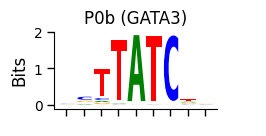

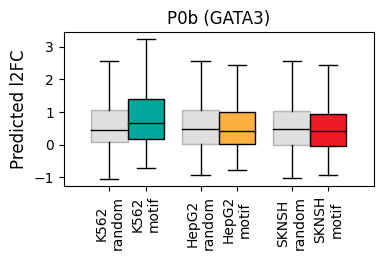

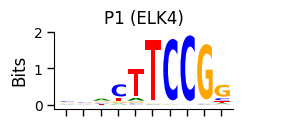

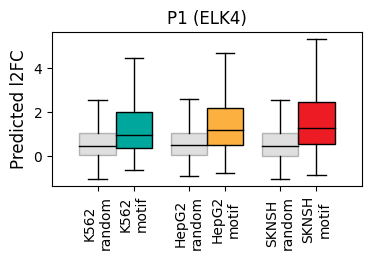

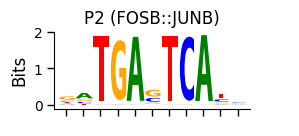

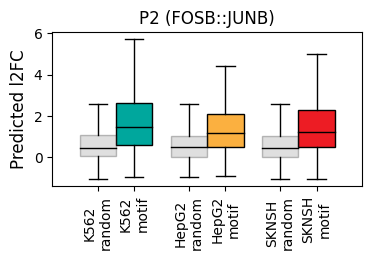

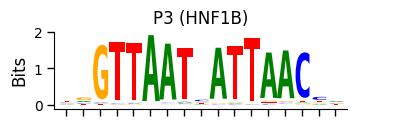

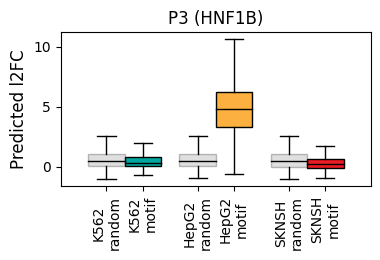

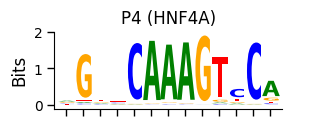

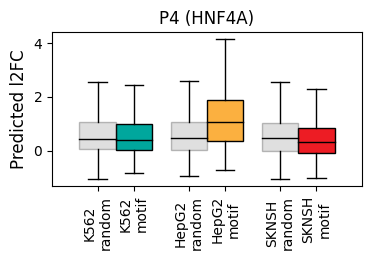

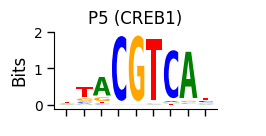

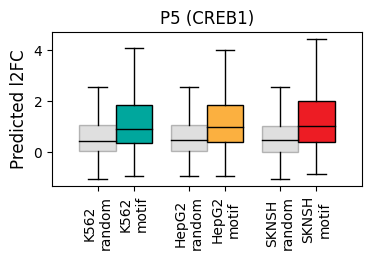

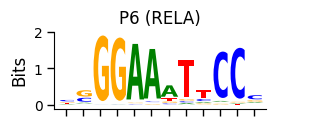

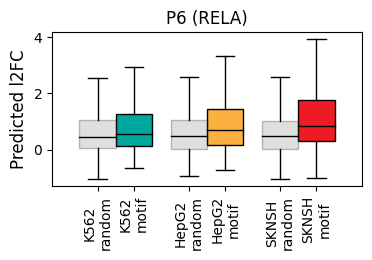

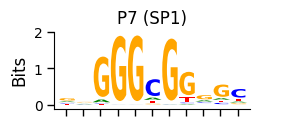

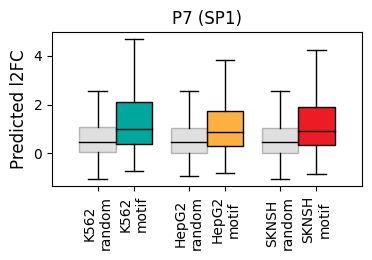

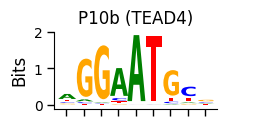

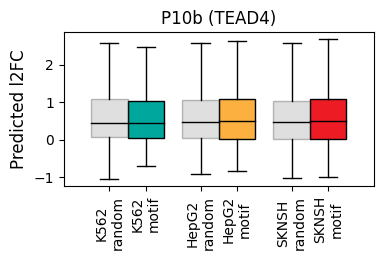

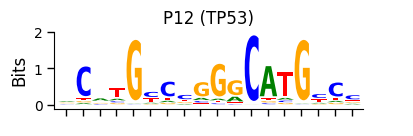

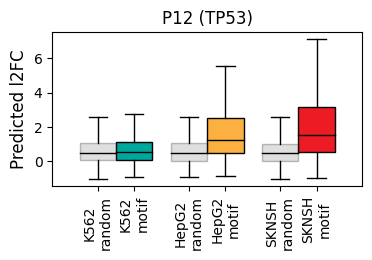

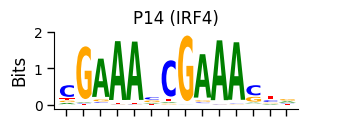

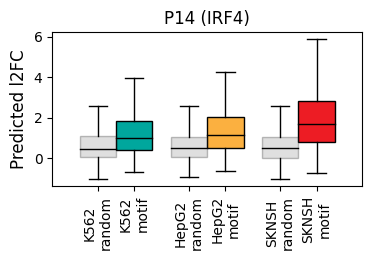

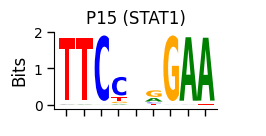

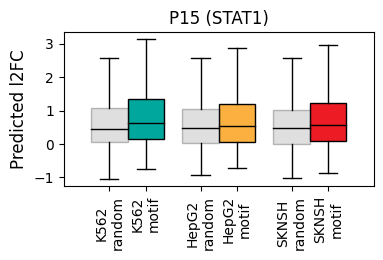

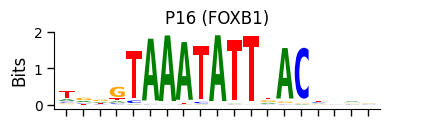

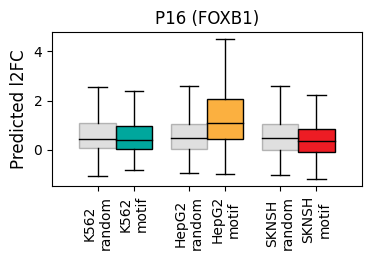

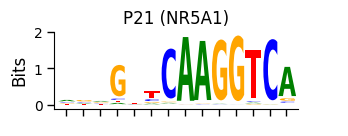

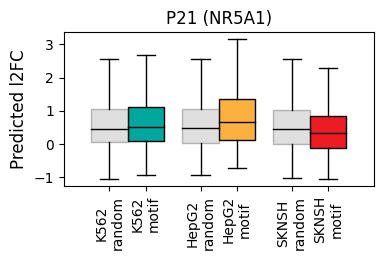

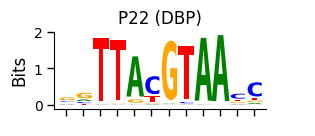

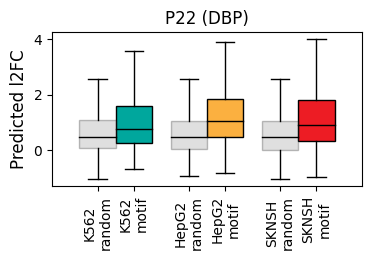

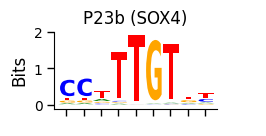

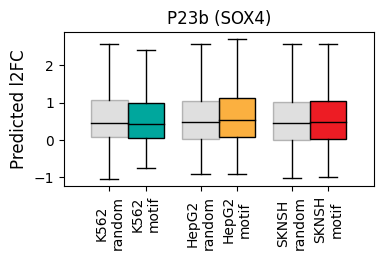

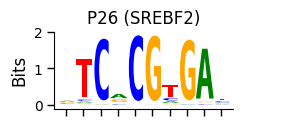

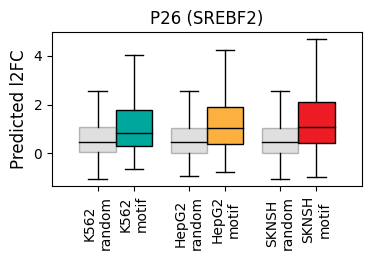

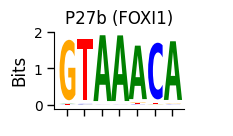

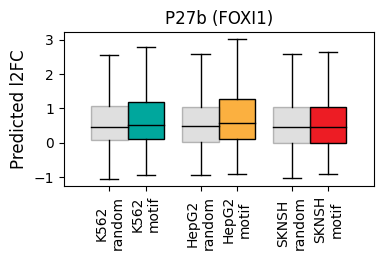

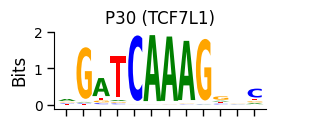

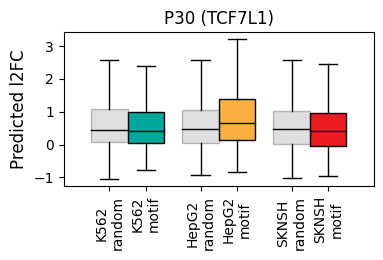

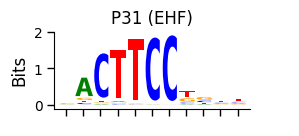

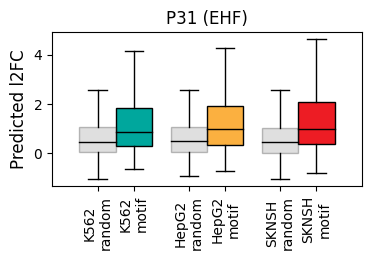

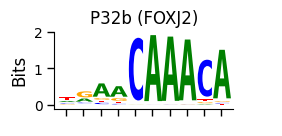

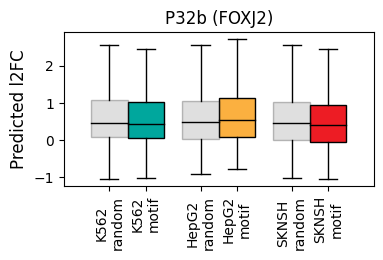

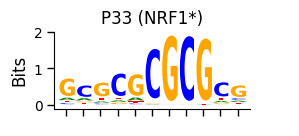

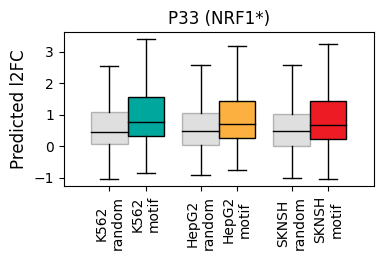

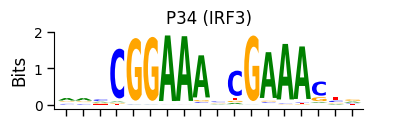

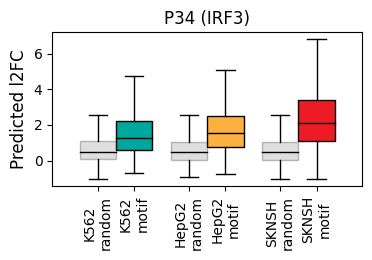

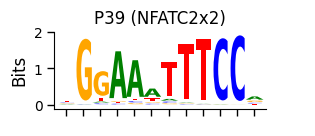

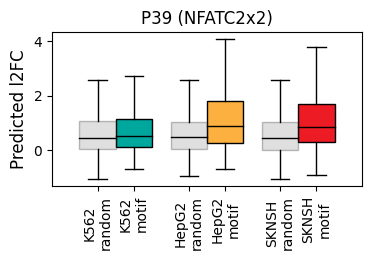

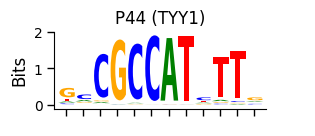

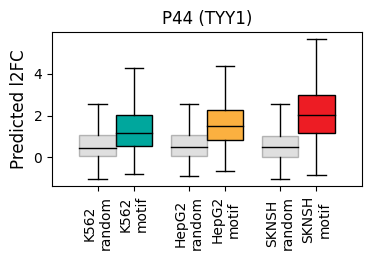

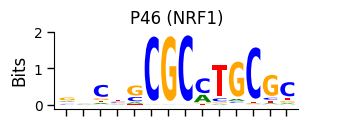

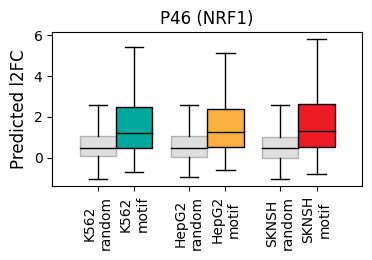

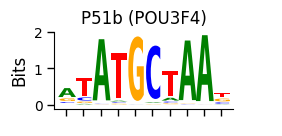

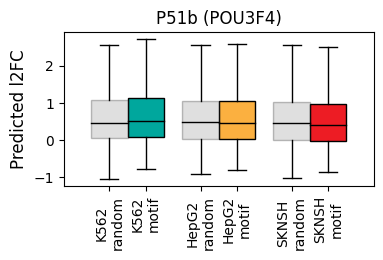

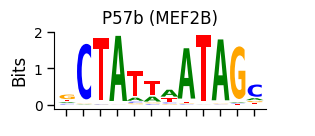

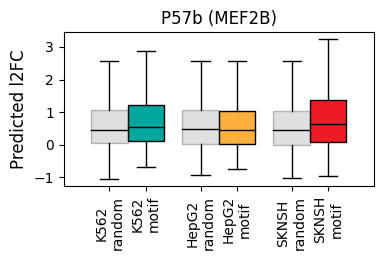

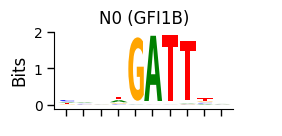

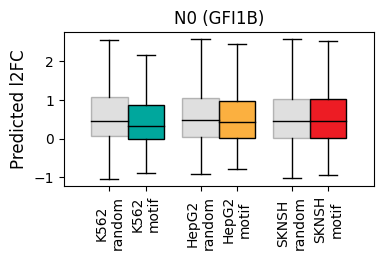

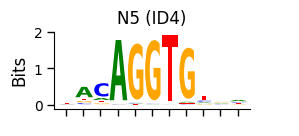

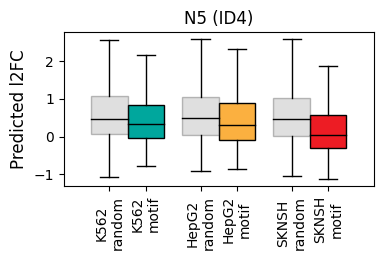

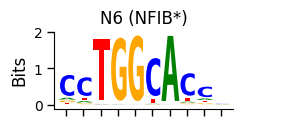

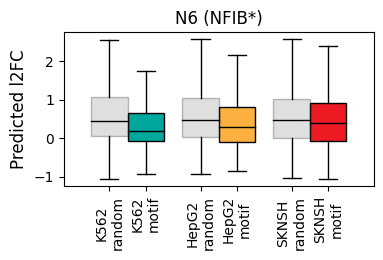

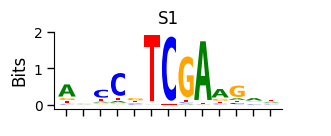

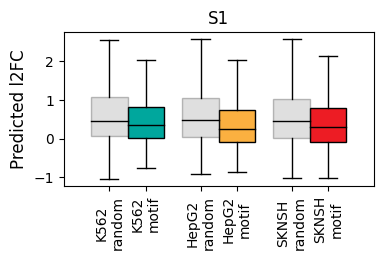

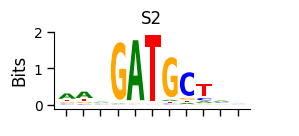

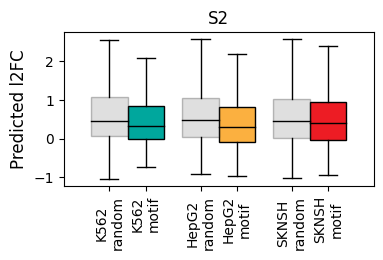

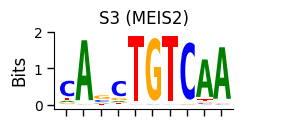

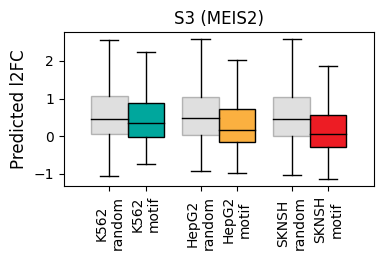

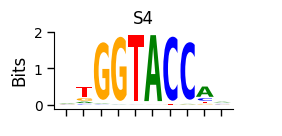

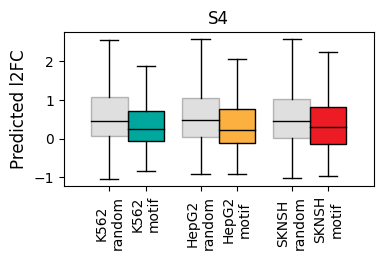

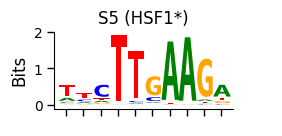

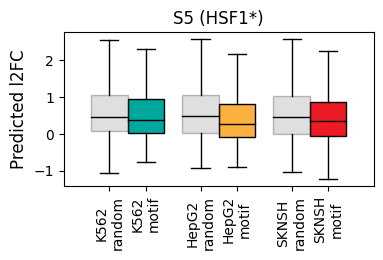

In [ ]:
for j, motif_id in enumerate(flipped_custom_motif_names):
    motif_icm = core_motif_icms[j]

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('Bits', fontsize=12)
    plt.tick_params(labelbottom=False)
    plt.yticks([0,1,2], fontsize=10)
    plt.title(f'{motif_id}')
    save_path = f"/content/drive/MyDrive/figures/motif_catalog/core_motif_logos/{motif_ids[j]}_logo.pdf"
    plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

    plt.figure(figsize=(4, 2))
    boxplot = plt.boxplot(preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\nmotif' for cell_type in cell_types], patch_artist=True)
    boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\nrandom' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC', fontsize=12)
    plt.title(f'{motif_id}')
    plt.xticks(rotation=90)
    save_path = f"/content/drive/MyDrive/figures/motif_catalog/core_motif_embedding/{motif_ids[j]}_embedding.pdf"
    plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

    print()

# Modisco pattenrs random embeddings

In [ ]:
all_pattern_ppms_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_modisco_transformed_untrimmed_tensors.pt")

pattern_names = list(all_pattern_ppms_dict.keys())
all_pattern_ppms = list(all_pattern_ppms_dict.values())
all_pattern_icms = [ppm_to_IC(ppm) for ppm in all_pattern_ppms]

In [ ]:
probs = []
for motif_ppm in all_pattern_ppms:
    left_size, right_size = int(np.floor(motif_ppm.shape[1] / 2)), int(np.ceil(motif_ppm.shape[1] / 2))
    #left_size, right_size = int(np.floor(2 * motif_ppm.shape[1] / 3)), int(np.ceil(motif_ppm.shape[1] / 3))
    random_prob_left_pad = 0.25 * torch.ones((4, 100 - left_size))
    random_prob_right_pad = 0.25 * torch.ones((4, 100 - right_size))
    probs.append(torch.cat([random_prob_left_pad, motif_ppm, random_prob_right_pad], dim=-1))

probs.append(0.25 * torch.ones((4, 200)))
probs = torch.stack(probs)

In [ ]:
n_samples = 5000

batch_size = 1024
token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0], samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())

preds = torch.cat(preds, dim=0).unflatten(0, (n_samples, probs.shape[0]))

  0%|          | 0/328 [00:00<?, ?it/s]

In [ ]:
for j, motif_id in enumerate(pattern_names):
    motif_icm = all_pattern_icms[j]

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('Bits', fontsize=12)
    plt.tick_params(labelbottom=False)
    plt.yticks([0,1,2], fontsize=10)
    plt.title(f'{motif_id}')
    save_path = f"/content/drive/MyDrive/figures/motif_catalog/modisco_transformed_logos/{pattern_names[j]}_logo.pdf"
    plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

    plt.figure(figsize=(4, 2))
    boxplot = plt.boxplot(preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\nmotif' for cell_type in cell_types], patch_artist=True)
    boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\nrandom' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC', fontsize=12)
    plt.title(f'{motif_id}')
    plt.xticks(rotation=90)
    save_path = f"/content/drive/MyDrive/figures/motif_catalog/modisco_transformed_embedding/{pattern_names[j]}_embedding.pdf"
    plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

# Modisco patterns original logos

In [ ]:
pos_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_pos_patterns.pt')
neg_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_neg_patterns.pt')

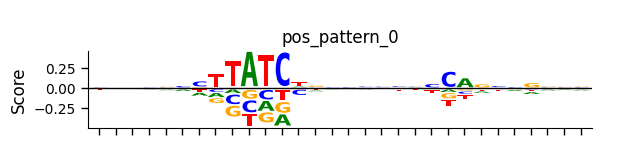

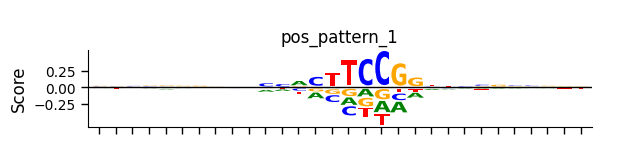

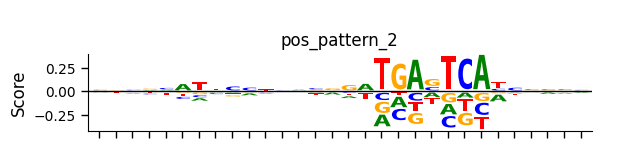

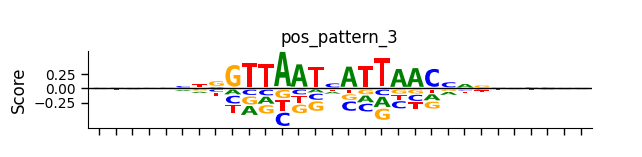

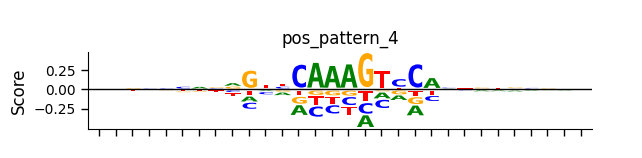

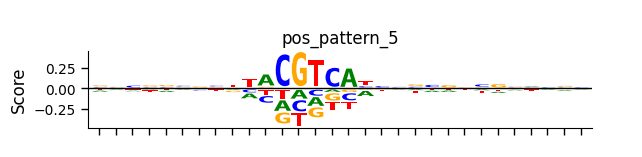

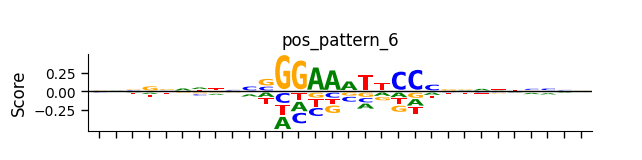

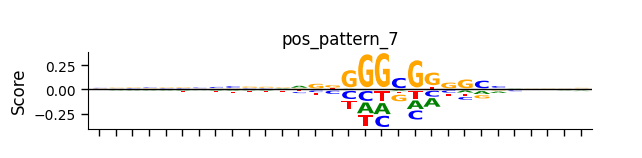

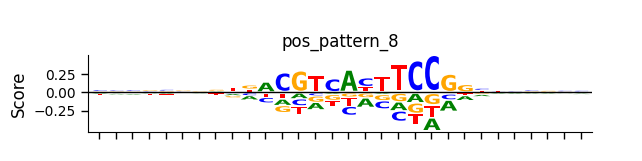

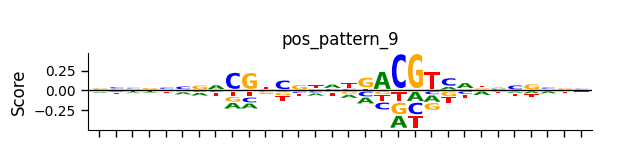

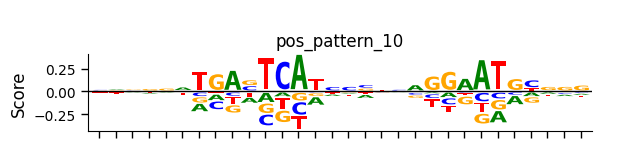

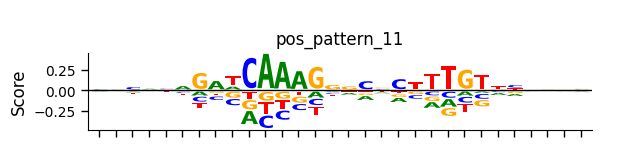

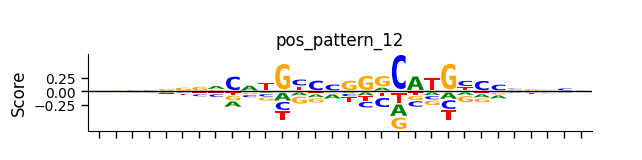

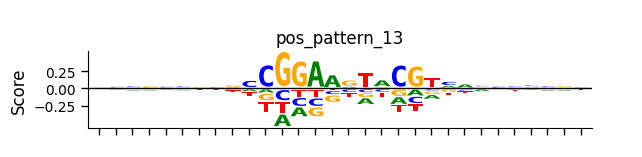

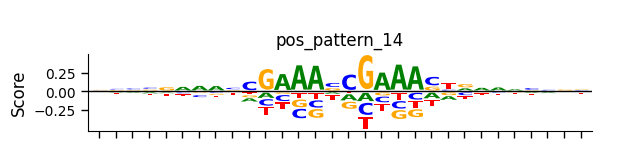

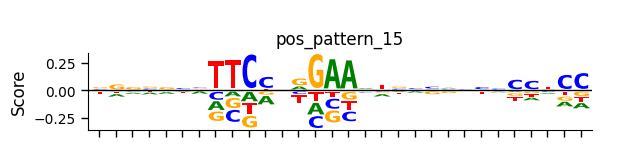

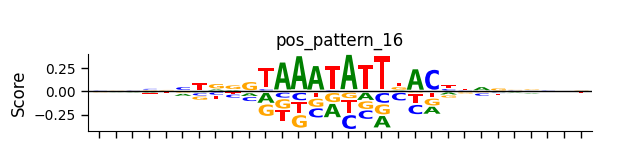

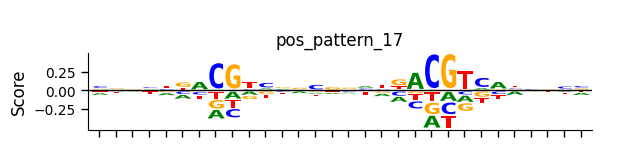

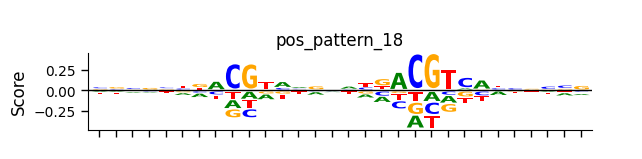

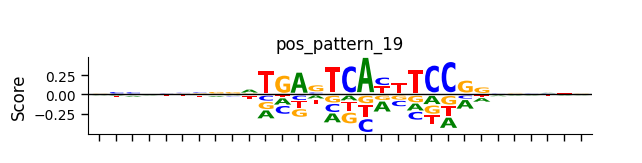

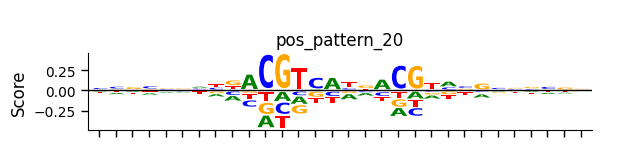

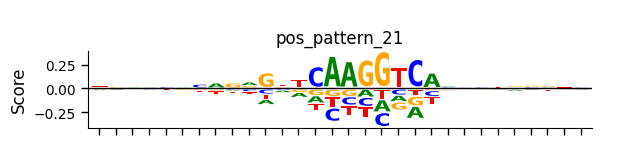

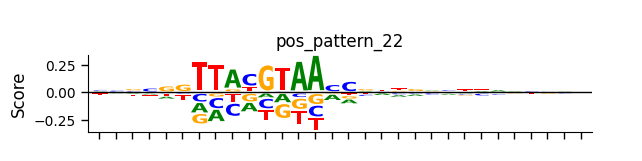

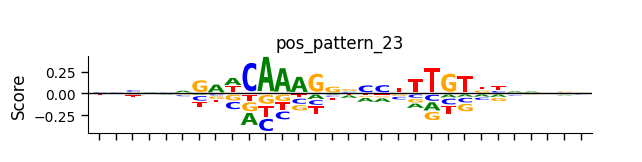

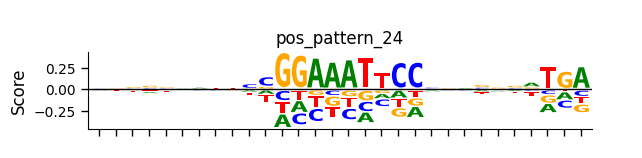

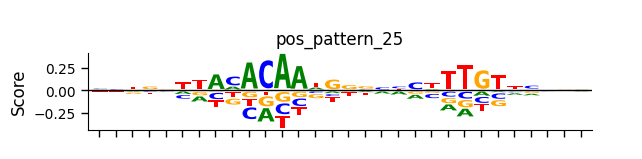

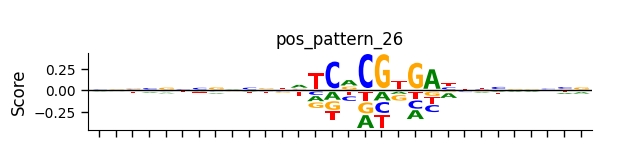

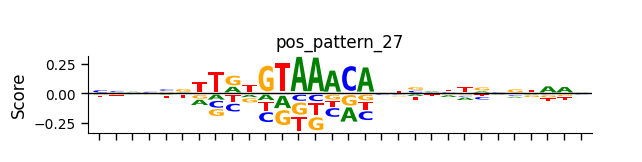

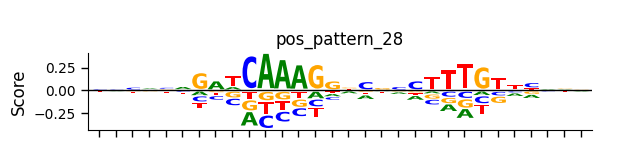

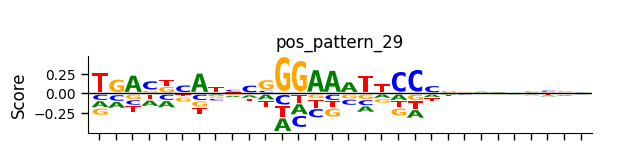

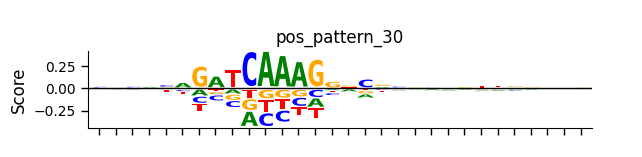

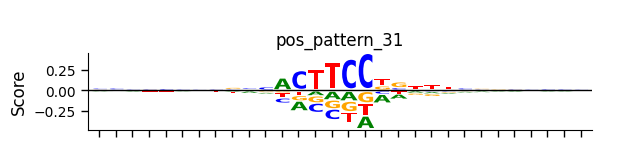

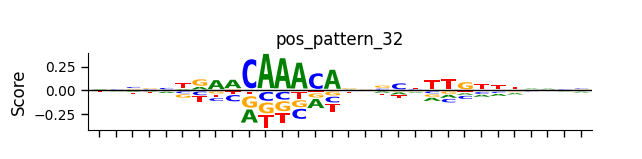

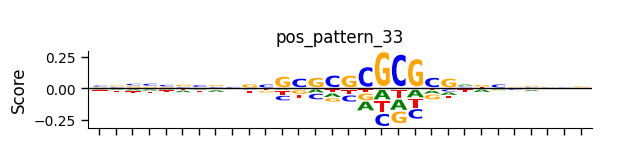

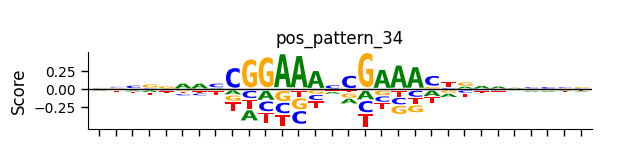

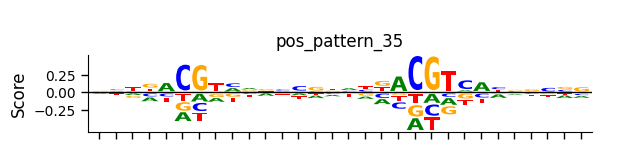

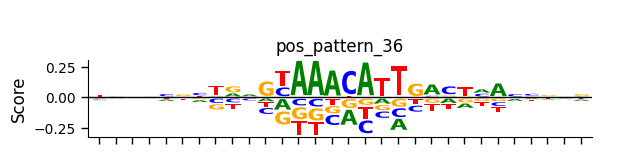

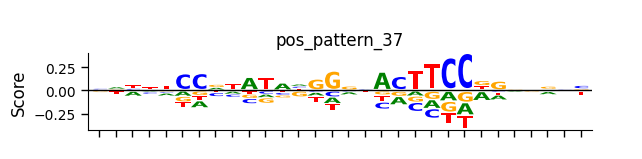

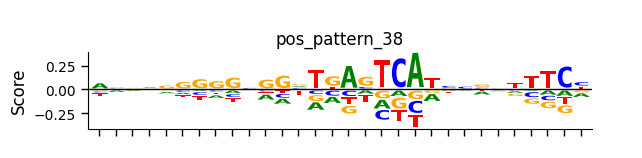

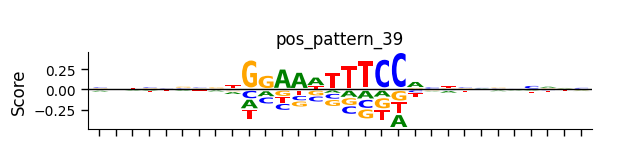

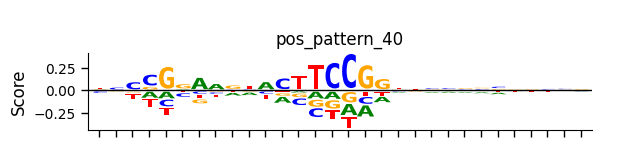

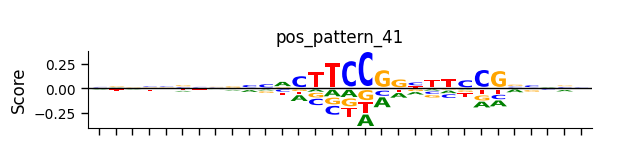

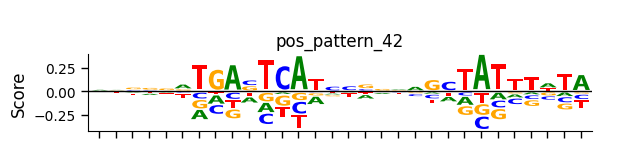

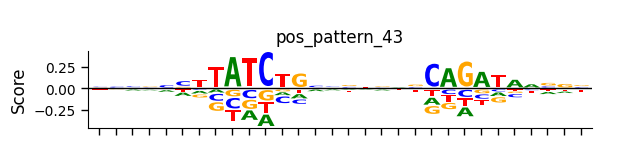

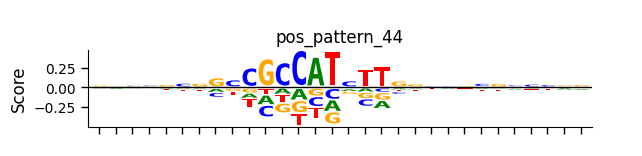

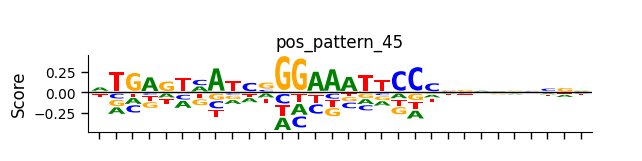

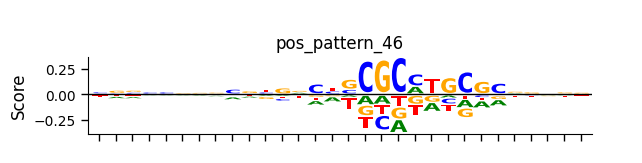

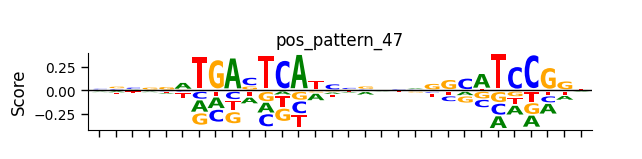

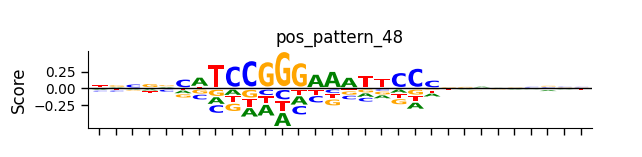

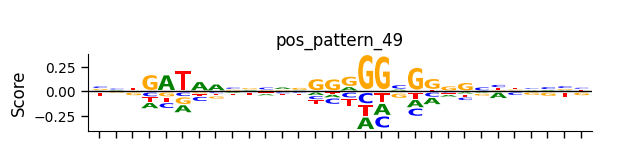

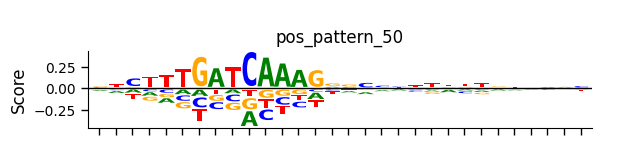

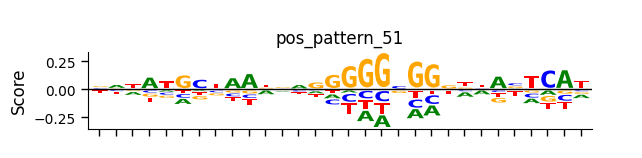

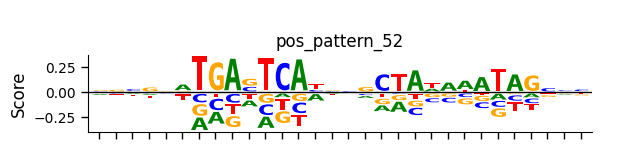

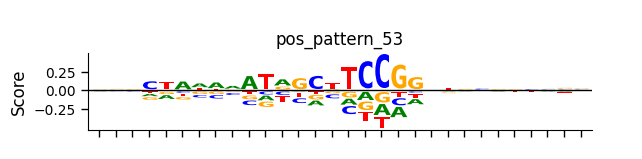

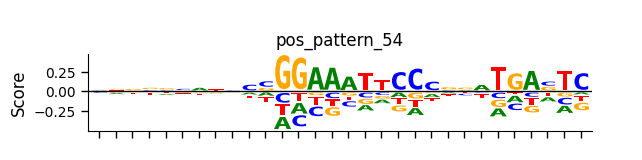

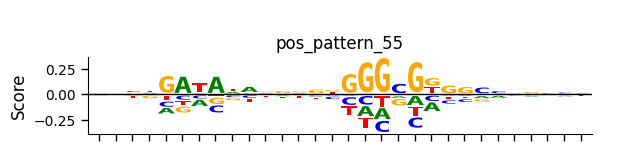

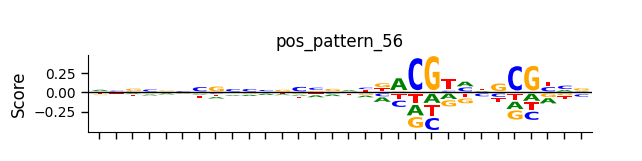

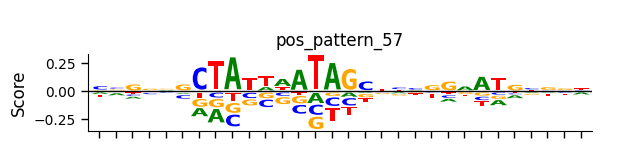

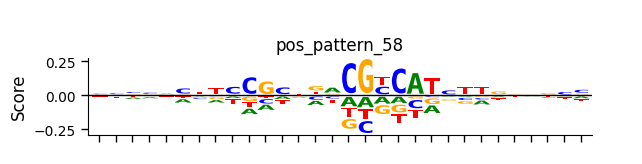

In [ ]:
loaded_patterns = pos_pattern_dict['merged_pattern_hypscores']

for pattern_idx in range(loaded_patterns.shape[0]):
    pattern_scores = loaded_patterns[pattern_idx, ...]

    plot_tensor = torch.Tensor(pattern_scores).T
    y_max = plot_tensor.max()
    matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('Score', fontsize=12)
    plt.yticks([-0.25, 0, 0.25], fontsize=10)
    plt.tick_params(labelbottom=False)
    plt.title(f'pos_pattern_{pattern_idx}')
    save_path = f"/content/drive/MyDrive/figures/motif_catalog/modisco_original_logos/pos_pattern_{pattern_idx}_scores.pdf"
    plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

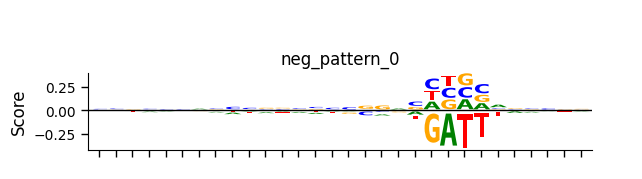

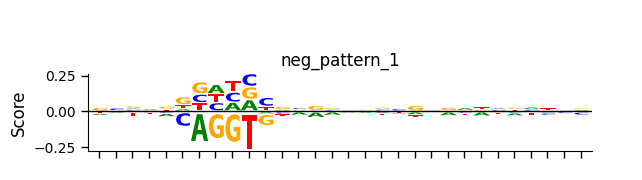

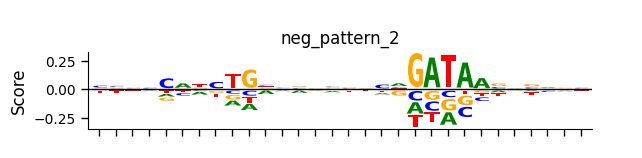

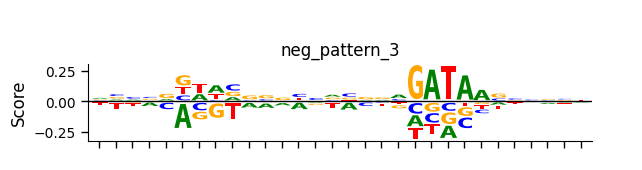

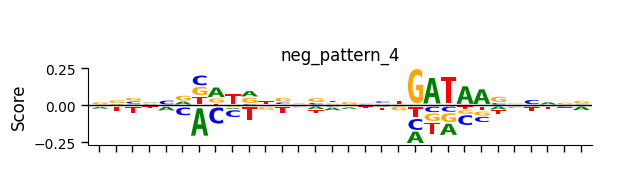

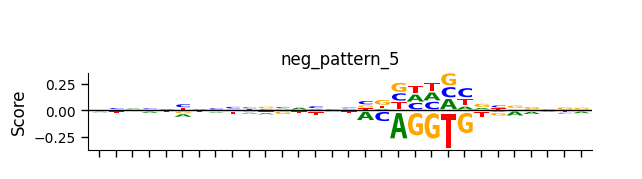

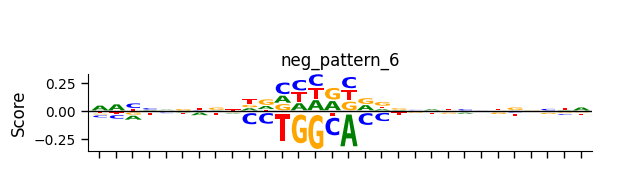

In [ ]:
loaded_patterns = np.stack(neg_pattern_dict['merged_pattern_hypscores'], axis=0)

for pattern_idx in range(loaded_patterns.shape[0]):
    pattern_scores = loaded_patterns[pattern_idx, ...]

    plot_tensor = torch.Tensor(pattern_scores).T
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
    matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('Score', fontsize=12)
    plt.yticks([-0.25, 0, 0.25], fontsize=10)
    plt.tick_params(labelbottom=False)
    plt.title(f'neg_pattern_{pattern_idx}')
    save_path = f"/content/drive/MyDrive/figures/motif_catalog/modisco_original_logos/neg_pattern_{pattern_idx}_scores.pdf"
    plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

# Core motif ablation

In [33]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

core_motif_ppms = list(tensor_motif_dict.values())
core_motif_pwms = [ppm_to_pwm(ppm) for ppm in core_motif_ppms]
core_motif_icms = [ppm_to_IC(ppm) for ppm in core_motif_ppms]

core_motif_ppms_rc = [utils.reverse_complement_onehot(ppm) for ppm in core_motif_ppms]
core_motif_pwms_rc = [utils.reverse_complement_onehot(pwm) for pwm in core_motif_pwms]
core_motif_icms_rc = [utils.reverse_complement_onehot(icm) for icm in core_motif_icms]


custom_motif_names = ['(GATA3) P0b', '(ELK4) P1', '(FOSB::JUNB) P2', '(HNF1B) P3', '(HNF4A) P4', '(CREB1) P5', '(RELA) P6', '(SP1) P7',
                      '(TEAD4) P10b', '(TP53) P12', '(IRF4) P14', '(STAT1) P15', '(FOXB1) P16', '(NR5A1) P21', '(DBP) P22', '(SOX4) P23b',
                      '(SREBF2) P26', '(FOXI1) P27b', '(TCF7L1) P30', '(EHF) P31', '(FOXJ2) P32b', '(NRF1*) P33', '(IRF3) P34',
                      '(NFATC2x2) P39', '(TYY1) P44', '(NRF1) P46', '(POU3F4) P51b', '(MEF2B) P57b',
                      '(GFI1B) N0', '(ID4) N5', '(NFIB*) N6', 'S1', 'S2', '(MEIS2) S3', 'S4', '(HSF1*) S5'
                      ]

flipped_custom_motif_names = [label.split(' ')[1] + ' ' + label.split(' ')[0] \
                              if (len(label.split(' '))>1) else label.split(' ')[0] for label in custom_motif_names ]

In [34]:
#contribution_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full.tsv', sep='\t')
#contribution_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full_min_overlap.tsv', sep='\t')

fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')
#fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')

fimo_df['score'] = fimo_df['gradients_pearson']
fimo_df['p_value'] = fimo_df['gradients_pearson']

In [35]:
counts = []
for motif_idx, motif_id in enumerate(motif_ids):
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    counts.append(len(motif_df['sequence_name'].unique()))
5 * np.sum(counts)

3302165

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

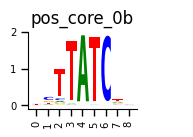

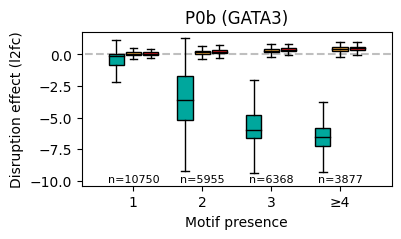

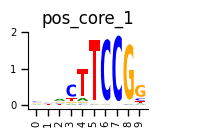

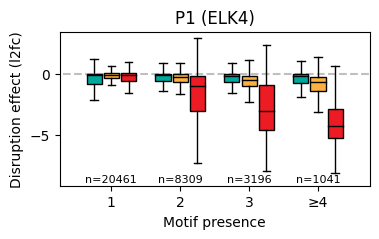

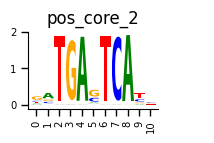

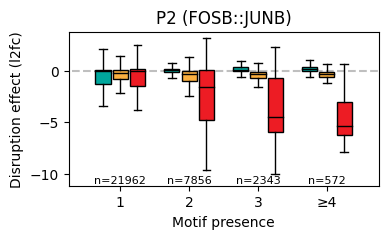

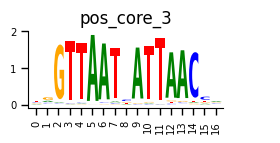

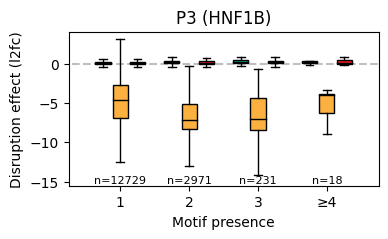

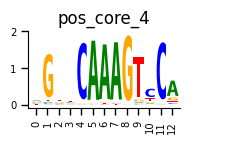

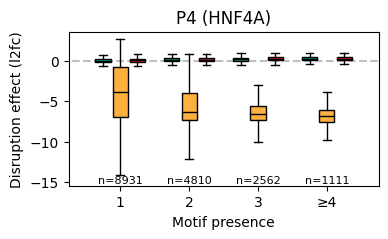

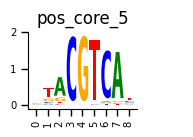

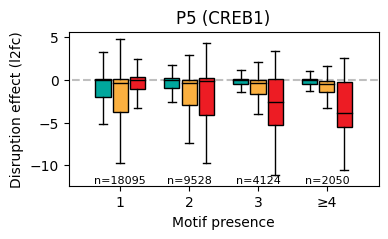

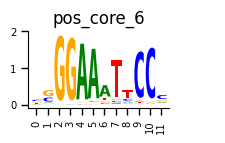

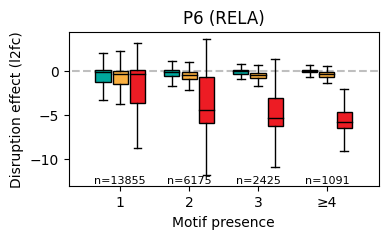

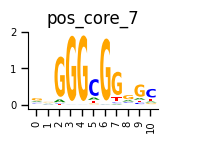

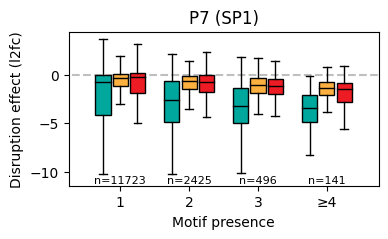

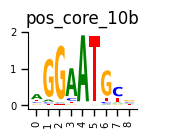

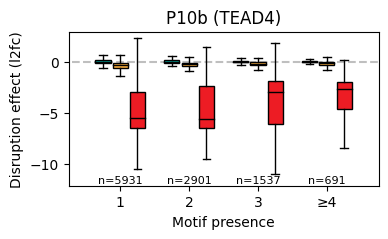

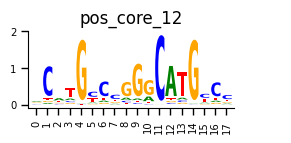

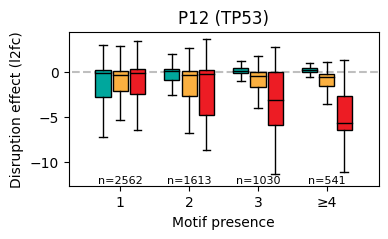

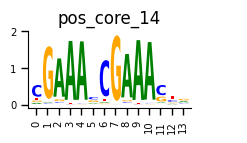

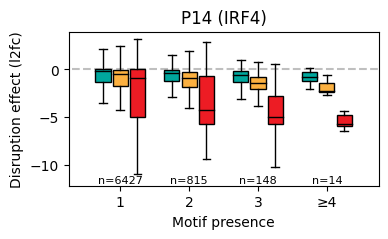

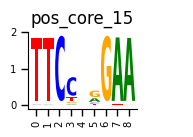

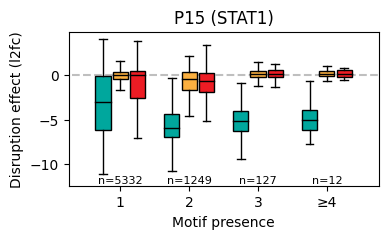

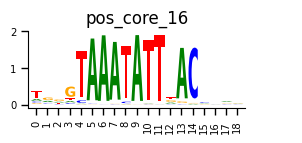

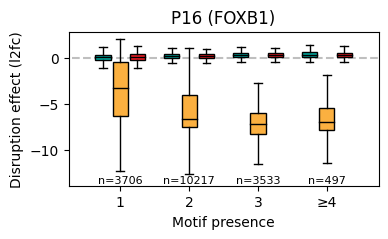

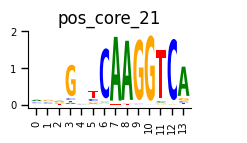

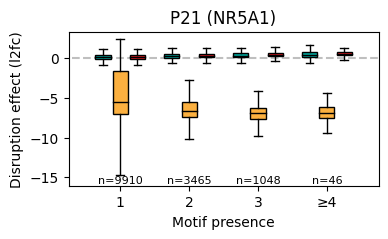

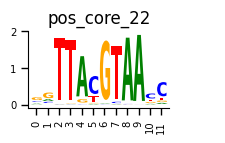

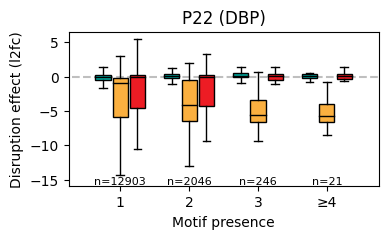

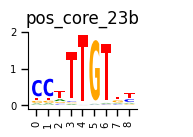

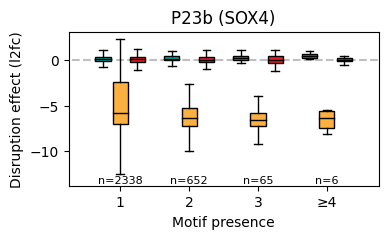

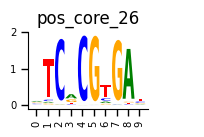

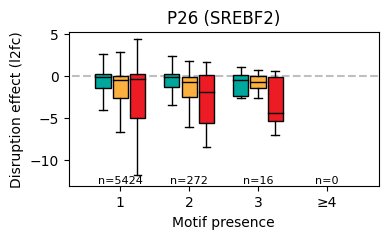

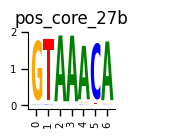

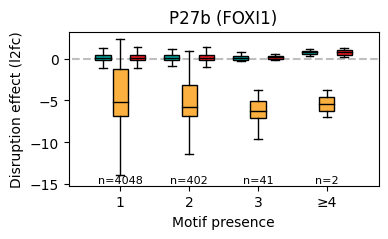

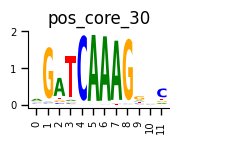

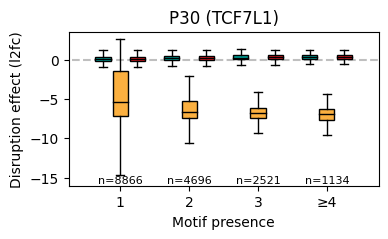

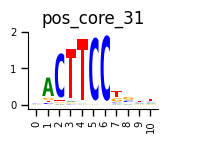

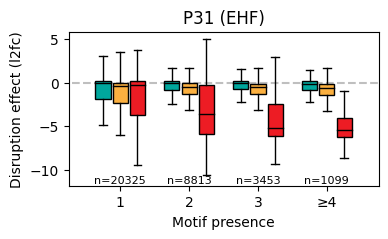

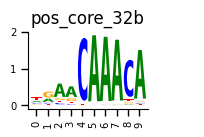

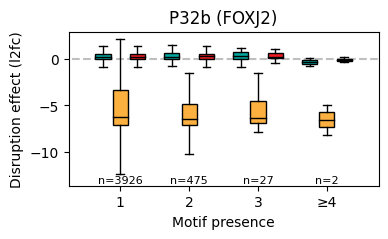

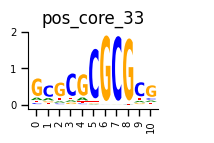

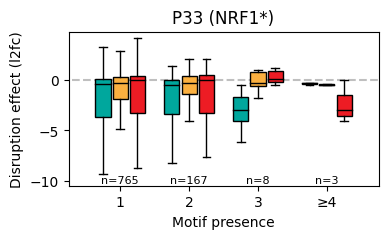

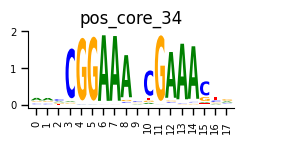

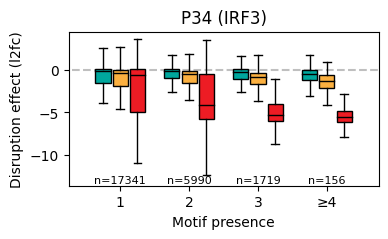

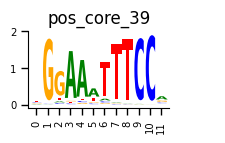

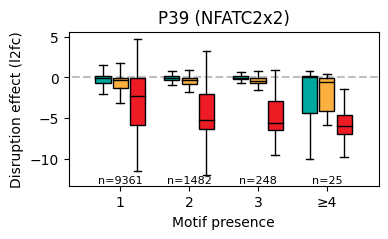

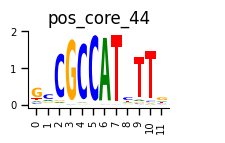

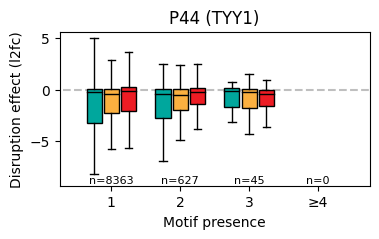

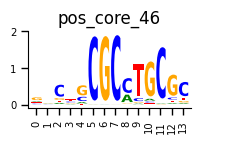

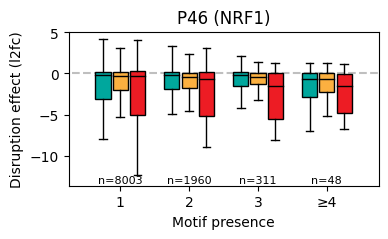

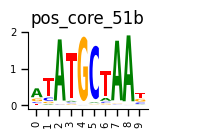

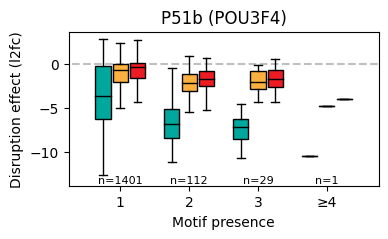

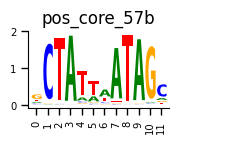

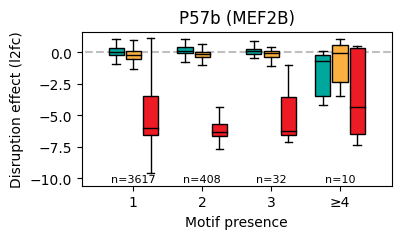

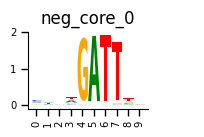

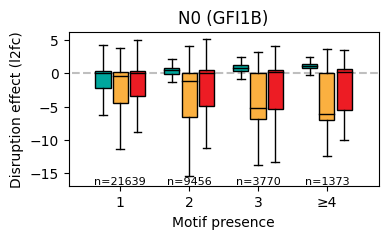

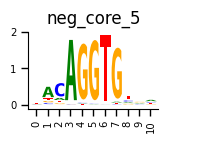

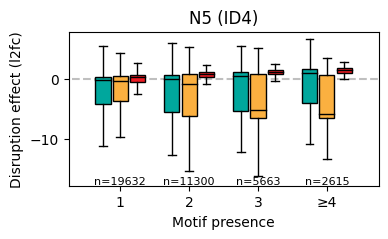

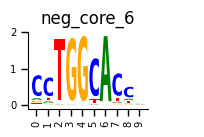

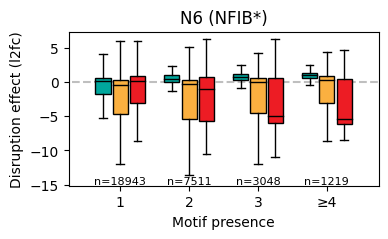

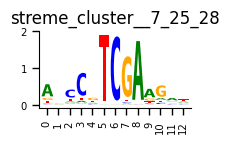

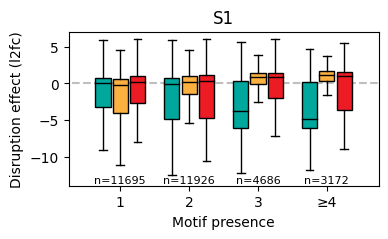

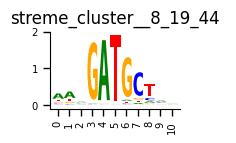

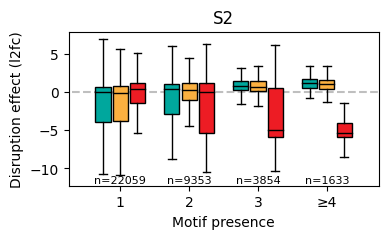

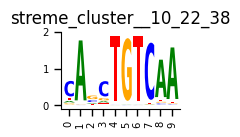

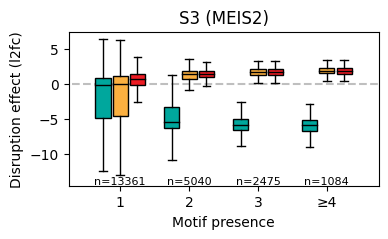

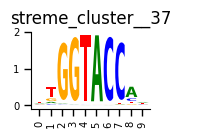

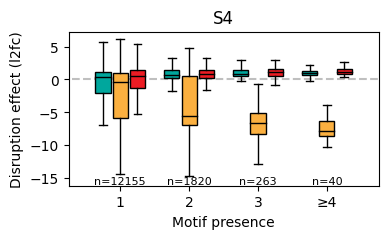

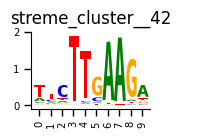

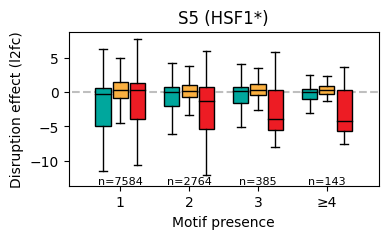

In [ ]:
num_disruptions = 5
#fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)                  #For FIMO
fimo_df = fimo_df[(fimo_df['start'] >= 0) & (fimo_df['stop'] <= 200)].reset_index(drop=True)    #For gradient-based matches

id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_idx, motif_id in enumerate(motif_ids):
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = tensor_motif_dict[motif_id]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = ppm_to_IC(motif_ppm)
        #motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())       #For FIMO
        motif_max_score = motif_df['score'].max()                                                       #For gradient-based matches

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id)
        plt.show()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        motif_df = motif_df.sort_values('gradients_pearson', ascending=False).drop_duplicates(['sequence_name', 'start', 'stop']).sort_index()

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        # xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        # for i in range(3):
        #     # y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
        #     # ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        #     ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
        # ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # ax1.set_xlabel('Motif presence')
        # ax1.set_ylabel('Motif disruption effect (l2fc)')
        # ax1.set_title(motif_id)
        # hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        # ax2.set_xlabel('Motif presence')
        # ax2.set_ylabel('Frequency')
        # ax1.set_xlim(0, 1)
        # ax2.set_xlim(0, 1)
        # ax1.set_xticks(xtick_positions)
        # ax2.set_xticks(xtick_positions)
        # plt.tight_layout()
        # plt.show()

        sorted_motif_disruption_skews = motif_disruption_skews[sorting, :]
        binned_skews = []
        for presence_threshold in range(4):
            row_filter = (sorted_presences < presence_threshold + 1) & (sorted_presences > presence_threshold)
            binned_skews.append(sorted_motif_disruption_skews[row_filter, :].numpy())
        ns = [x.shape[0] for x in binned_skews]

        idx_divisor = 4
        fig = plt.figure(figsize=(4, 2))
        ax = plt.gca()
        for cell_idx, c in enumerate(cell_colors):
            for bin_idx, skew_bin in enumerate(binned_skews):
                ax.boxplot(skew_bin[:, cell_idx], positions=[cell_idx/idx_divisor + bin_idx] , widths=0.22, showfliers=False, patch_artist=True,
                            boxprops=dict(facecolor=c, color='black'),
                            capprops=dict(color='black'),
                            whiskerprops=dict(color='black'),
                            flierprops=dict(color=c, markeredgecolor='black'),
                            medianprops=dict(color='black'),
                            )
        ymin, ymax = ax.get_ylim()
        for i in range(0,4):
            ax.text(1/idx_divisor + i, ymin - 0.25, f'n={ns[i]}', fontsize=8, horizontalalignment='center')
        ax.set_ylim([ymin - 0.5, ymax])
        ax.hlines(0, -0.45, 4, linestyles='dashed', color='grey', alpha=0.5, zorder=0)
        ax.set_xlabel('Motif presence', fontsize=10)
        ax.set_ylabel('Disruption effect (l2fc)', fontsize=10)
        ax.set_xticks([1/idx_divisor + i for i in range(0,4)], labels=['1', '2', '3', '≥4'])
        ax.set_title(flipped_custom_motif_names[motif_idx], fontsize=12)
        save_path = f"/content/drive/MyDrive/figures/motif_catalog/core_motif_ablation/{motif_id}_ablation.pdf"
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
        plt.show()
    print()

#Modisco pattern ablation

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

In [36]:
all_pattern_ppms_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_modisco_transformed_untrimmed_tensors.pt")

pattern_names = list(all_pattern_ppms_dict.keys())
all_pattern_ppms = list(all_pattern_ppms_dict.values())
all_pattern_icms = [ppm_to_IC(ppm) for ppm in all_pattern_ppms]

In [37]:
full_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_modisco_fimo_v2.tsv', sep='\t')
full_fimo_df = full_fimo_df[:-3]

full_fimo_df['start'] = full_fimo_df['start'].astype(int) - 1
full_fimo_df['stop'] = full_fimo_df['stop'].astype(int)

full_fimo_df = full_fimo_df[full_fimo_df['sequence_name'].isin(onehots_dict['IDs'])].reset_index(drop=True)
fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

In [39]:
original_pattern_names = [x.split('_')[0] + '_patterns_' + x.split('_')[2] for x in pattern_names]

counts = []
for motif_idx, motif_id in enumerate(original_pattern_names):
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    counts.append(len(motif_df['sequence_name'].unique()))
5 * np.sum(counts)

2154480

In [ ]:
num_disruptions = 5
#fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)                  #For FIMO
#fimo_df = fimo_df[(fimo_df['start'] >= 0) & (fimo_df['stop'] <= 200)].reset_index(drop=True)    #For gradient-based matches

original_pattern_names = [x.split('_')[0] + '_patterns_' + x.split('_')[2] for x in pattern_names]
id_to_idx = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_disruption_dict = {}
all_motif_preds = {}
for motif_idx, motif_id in enumerate(original_pattern_names):
    motif_df = fimo_df[fimo_df['motif_id'] == motif_id].reset_index(drop=True)
    if len(motif_df) == 0:
        print(f'No instances found for {motif_id}')
        pass
    else:
        #print(f'Retreiving sequences and positions to disrupt {motif_id}')
        motif_df['seq_idx'] = [id_to_idx[id] for id in motif_df['sequence_name'].tolist()]
        motif_df.sort_values('seq_idx', inplace=True)

        motif_ppm = all_pattern_ppms[motif_idx]
        motif_pwm = ppm_to_pwm(motif_ppm)
        motif_icm = all_pattern_icms[motif_idx]
        motif_max_score = max(motif_pwm.max(dim=0).values.sum().item(), motif_df['score'].max())       #For FIMO
        #motif_max_score = motif_df['score'].max()                                                       #For gradient-based matches

        matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([0,1,2])
        plt.title(motif_id)
        plt.show()

        motif_df['presence_share'] = motif_df['score'] / motif_max_score
        motif_df['interval'] = motif_df.apply(lambda row: np.arange(row['start'], row['stop']), axis=1)

        motif_df = motif_df.sort_values('score', ascending=False).drop_duplicates(['sequence_name', 'start', 'stop']).sort_index()

        grouped = motif_df.groupby('seq_idx')

        motif_seq_idxs = list(grouped.groups.keys())
        motif_seq_positions = [np.unique(np.concatenate(group['interval'].values)) for _, group in grouped ]
        motif_presences = grouped['presence_share'].sum().tolist()
        seq_motif_hits = grouped.size().tolist()

        all_motif_disruption_dict[motif_id] = [motif_seq_idxs, motif_seq_positions, motif_presences, seq_motif_hits]

        motif_disrupted_preds = []
        for n in range(num_disruptions):
            #print(f'Disruption {n + 1}/{num_disruptions}...')
            motif_disrupted_seqs = []
            for seq_idx, seq_positions in zip(motif_seq_idxs, motif_seq_positions):
                motif_disrupted_seq = seq_onehots[seq_idx, ...]
                random_tokens = torch.randint(0, 4, (len(seq_positions),))
                random_onehot = torch.zeros(4, len(seq_positions))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., seq_positions] = random_onehot
                motif_disrupted_seqs.append(motif_disrupted_seq)
            motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

            #print(f'Prediction {n + 1}/{num_disruptions}...')
            onehots = motif_disrupted_seqs.clone()
            #--- Predict ----
            left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
            right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
            pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                    onehots,
                    right_flank.repeat(onehots.shape[0], 1, 1)]
            in_tensor = torch.cat( pieces, axis=-1)
            temp_dataset = TensorDataset(in_tensor)
            temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
            preds = []
            for local_batch in temp_dataloader:
                preds.append(model(local_batch[0].cuda()).detach().cpu())
            #---
            preds = torch.cat(preds, dim=0)
            motif_disrupted_preds.append(preds)

        motif_disrupted_preds = torch.stack(motif_disrupted_preds, dim=0).mean(dim=0)
        motif_original_preds = original_preds[motif_seq_idxs, ...]
        motif_disruption_skews = motif_disrupted_preds - motif_original_preds

        all_motif_preds[motif_id] = [motif_original_preds, motif_disrupted_preds, motif_disruption_skews]

        sorting = np.argsort(motif_presences)
        sorted_presences = np.sort(motif_presences)

        # plt.figure(figsize=(5,3))
        # for i in range(3):
        #     y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=5)
        #     plt.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        # plt.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # plt.xlabel('Motif presence')
        # plt.ylabel('Motif disruption effect (l2fc)')
        # plt.title(motif_id)
        # plt.show()

        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [3, 1]})
        # xtick_positions = np.arange(0, np.ceil(max(sorted_presences)))
        # for i in range(3):
        #     # y_smoothed = gaussian_filter1d(motif_disruption_skews[sorting, i].numpy(), sigma=3)
        #     # ax1.plot(sorted_presences, y_smoothed, color=cell_colors[i], alpha=0.75)
        #     ax1.scatter(sorted_presences, motif_disruption_skews[sorting, i].numpy(), color=cell_colors[i], alpha=0.5, marker='.', s=5)
        # ax1.hlines(0, 0, np.max(sorted_presences), linestyles='dashed', color='grey', alpha=0.25, zorder=0)
        # ax1.set_xlabel('Motif presence')
        # ax1.set_ylabel('Motif disruption effect (l2fc)')
        # ax1.set_title(motif_id)
        # hist, bin_edges, _ = ax2.hist(sorted_presences, bins=200, color='skyblue', alpha=1)
        # ax2.set_xlabel('Motif presence')
        # ax2.set_ylabel('Frequency')
        # ax1.set_xlim(0, 1)
        # ax2.set_xlim(0, 1)
        # ax1.set_xticks(xtick_positions)
        # ax2.set_xticks(xtick_positions)
        # plt.tight_layout()
        # plt.show()

        sorted_motif_disruption_skews = motif_disruption_skews[sorting, :]
        binned_skews = []
        for presence_threshold in range(4):
            row_filter = (sorted_presences < presence_threshold + 1) & (sorted_presences > presence_threshold)
            binned_skews.append(sorted_motif_disruption_skews[row_filter, :].numpy())
        ns = [x.shape[0] for x in binned_skews]

        idx_divisor = 4
        fig = plt.figure(figsize=(4, 2))
        ax = plt.gca()
        for cell_idx, c in enumerate(cell_colors):
            for bin_idx, skew_bin in enumerate(binned_skews):
                ax.boxplot(skew_bin[:, cell_idx], positions=[cell_idx/idx_divisor + bin_idx] , widths=0.22, showfliers=False, patch_artist=True,
                            boxprops=dict(facecolor=c, color='black'),
                            capprops=dict(color='black'),
                            whiskerprops=dict(color='black'),
                            flierprops=dict(color=c, markeredgecolor='black'),
                            medianprops=dict(color='black'),
                            )
        ymin, ymax = ax.get_ylim()
        for i in range(0,4):
            ax.text(1/idx_divisor + i, ymin - 0.25, f'n={ns[i]}', fontsize=8, horizontalalignment='center')
        ax.set_ylim([ymin - 0.5, ymax])
        ax.hlines(0, -0.45, 4, linestyles='dashed', color='grey', alpha=0.5, zorder=0)
        ax.set_xlabel('Motif presence', fontsize=10)
        ax.set_ylabel('Disruption effect (l2fc)', fontsize=10)
        ax.set_xticks([1/idx_divisor + i for i in range(0,4)], labels=['1', '2', '3', '≥4'])
        ax.set_title(pattern_names[motif_idx], fontsize=12)
        save_path = f"/content/drive/MyDrive/figures/motif_catalog/modisco_transformed_ablation/{pattern_names[motif_idx]}_ablation.pdf"
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches=0, dpi=200)
        plt.show()
    print()

Output hidden; open in https://colab.research.google.com to view.